# Advanced Deep Learning (D7047E) - Lab 2

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

## Initialize device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## MNIST Dataset Initialization

In [3]:
%%capture

BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_dataset = MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

X_train = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

X_test = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

## Task 1 - GAN

### Helpers

#### Constants

In [ ]:
# Latent variable size - Input G size
Z_dim = 128

# Hidden layer 1 size - G & D
h1_dim = Z_dim * 2

# Hidden layer 2 size - G
h2_dim = Z_dim * 4

# Output G / Input D size
X_dim = 28 * 28

# Labels size - CGAN
l_dim = 10

# Learning rate
lr = 2e-4

# Weight decay
weight_decay = 1e-5

#### Plotting functions

##### Samples

In [ ]:
def plot_samples_4x4_grid(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')

        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    plt.show()

##### Losses per epoch

In [ ]:
def plot_G_D_losses(G_losses, D_losses):
    plt.plot(G_losses, label='Generator Loss')
    plt.plot(D_losses, label='Discriminator Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.title('Generator & Discriminator Losses')
    plt.legend()

    plt.show()
    print("")

### Task 1.1 - Vanilla GAN

#### Helpers

##### Class definitions

###### Generator

Gets a 100-dimensional vector and returns a MNIST image.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()

        self.linear1 = torch.nn.Linear(Z_dim, h1_dim)
        self.linear2 = torch.nn.Linear(h1_dim, h2_dim)
        self.linear3 = torch.nn.Linear(h2_dim, X_dim)

        self.initialize_weights()

    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    module.bias.data.fill_(0.01)

    def forward(self, x):
        h1 = self.dropout(self.leaky_relu(self.linear1(x)))
        h2 = self.dropout(self.leaky_relu(self.linear2(h1)))

        return self.tanh(self.linear3(h2))

###### Discriminator

Gets a MNIST image and returns if it's real or fake

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

        self.linear1 = torch.nn.Linear(X_dim, h1_dim)
        self.linear2 = torch.nn.Linear(h1_dim, 1)

        self.initialize_weights()

    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    module.bias.data.fill_(0.01)

    def forward(self, x):
        h1 = self.dropout(self.leaky_relu(self.linear1(x)))

        return self.sigmoid(self.linear2(h1))

##### Train function

In [ ]:
def train_model(G, D, G_optimizer, D_optimizer, criterion, num_epochs):
    log_epoch = max(num_epochs // 10, 1)
    real_labels = torch.ones(BATCH_SIZE, 1).to(device)
    fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

    G_losses_per_epoch, D_losses_per_epoch = [], []

    for epoch in range(num_epochs):
        G_losses, D_losses = [], []
        G.train()
        D.train()

        for images, _ in X_train:
            images = images.view(-1, X_dim).to(device)

            # Train Discriminator
            z = torch.randn(BATCH_SIZE, Z_dim).to(device)

            D_optimizer.zero_grad()

            G_sample = G(z)
            D_real = D(images)
            D_fake = D(G_sample)

            D_real_loss = criterion(D_real, real_labels)
            D_fake_loss = criterion(D_fake, fake_labels)

            D_loss = D_real_loss + D_fake_loss

            D_loss.backward()
            D_optimizer.step()

            D_losses.append(D_loss.item())

            # Train Generator
            z = torch.randn(BATCH_SIZE, Z_dim).to(device)

            G_optimizer.zero_grad()

            G_sample = G(z)
            D_fake = D(G_sample)

            G_loss = criterion(D_fake, real_labels)

            G_loss.backward()
            G_optimizer.step()

            G_losses.append(G_loss.item())

        G_loss_per_epoch = np.mean(G_losses)
        D_loss_per_epoch = np.mean(D_losses)

        G_losses_per_epoch.append(G_loss_per_epoch)
        D_losses_per_epoch.append(D_loss_per_epoch)

        if (epoch + 1) % log_epoch == 0:
            G.eval()

            print(f"Epoch: {epoch + 1}", end=", ")
            print(f"D_loss: {D_loss_per_epoch}, G_loss: {G_loss_per_epoch}\n")

            z = torch.randn(4 * 4, Z_dim).to(device)

            with torch.no_grad():
                G_sample = G(z).detach().cpu()

            plot_samples_4x4_grid(G_sample)

    return G_losses_per_epoch, D_losses_per_epoch

#### Task 1.1.1 - Binary Cross Entropy Loss

##### Network Initialization

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

criterion = nn.BCELoss()

##### Training

This will run for approx. 100k iterations of 64-sized batches. (110 epochs * 59968 images / 64 batch_size = 110 * 937 = 103070)

Epoch: 11, D_loss: 0.9458517526358907, G_loss: 1.584467697041775



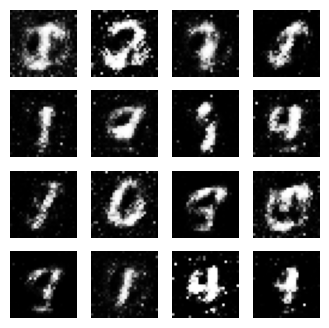

Epoch: 22, D_loss: 1.104162965920081, G_loss: 1.2328682499227046



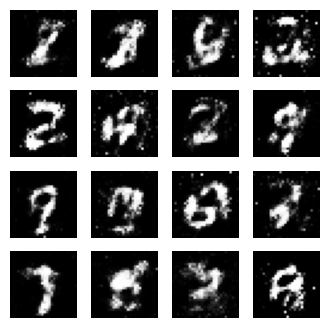

Epoch: 33, D_loss: 1.1829460853573606, G_loss: 1.059494315305667



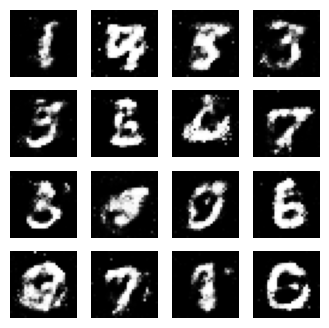

Epoch: 44, D_loss: 1.2489023213707142, G_loss: 0.9433130337563498



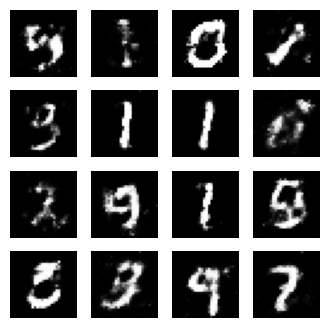

Epoch: 55, D_loss: 1.2739013107761883, G_loss: 0.89279077458916



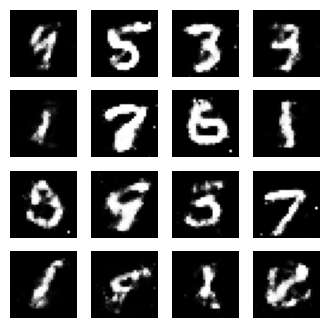

Epoch: 66, D_loss: 1.2862318576081968, G_loss: 0.8730557959769298



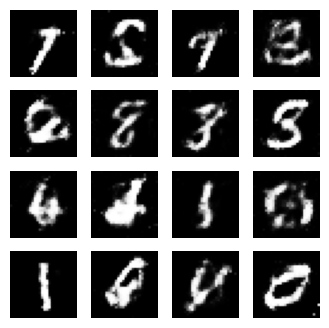

Epoch: 77, D_loss: 1.2927748048827132, G_loss: 0.8551429054017001



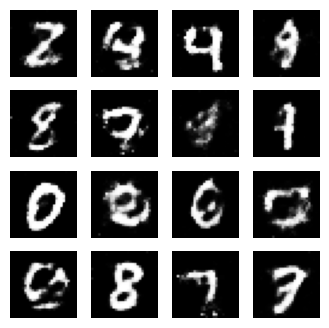

Epoch: 88, D_loss: 1.2980965422973307, G_loss: 0.8445730699164636



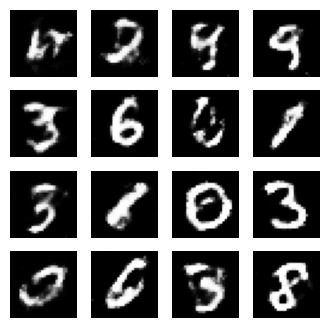

Epoch: 99, D_loss: 1.2947071482812074, G_loss: 0.8441776401714174



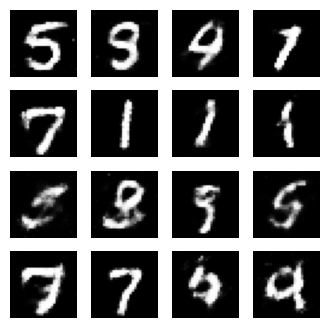

Epoch: 110, D_loss: 1.300637961070082, G_loss: 0.8397849448335336



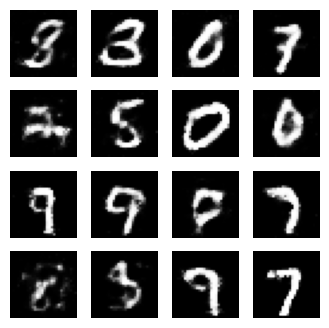

In [ ]:
G_losses, D_losses = train_model(
    G, D, G_optimizer, D_optimizer, criterion, num_epochs=110
)

##### Losses

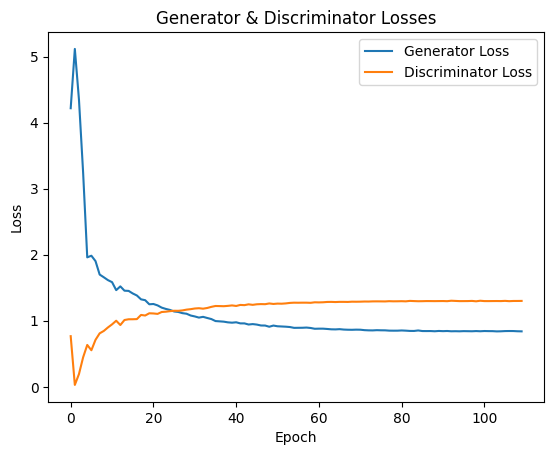

In [ ]:
plot_G_D_losses(G_losses, D_losses)

#### Task 1.1.2 - Binary Cross Entropy with Logits Loss

This loss combines a Sigmoid layer and the BCELoss in one single class, which is more numerically stable than using a plain Sigmoid followed by a BCELoss.

##### Helpers

###### Discriminator Class Definition for Logits

In [ ]:
class DiscriminatorLogits(Discriminator):
    def forward(self, x):
        h1 = self.dropout(self.leaky_relu(self.linear1(x)))

        return self.linear2(h1)

##### Task 1.1.2.1 - Training for 20k iterations

###### Network Initialization

In [ ]:
G = Generator().to(device)
D = DiscriminatorLogits().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

###### Training

This will run for approx. 20k iterations of 64-sized batches. (22 epochs * 59968 images / 64 batch_size = 22 * 937 = 20614)

Epoch: 2, D_loss: 0.03939809209469352, G_loss: 4.982864476827827



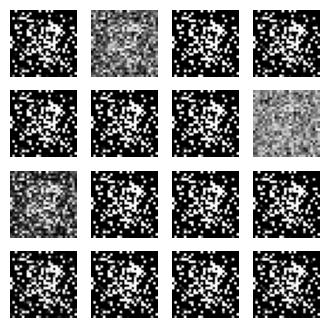

Epoch: 4, D_loss: 0.6338302865385882, G_loss: 2.180041952156079



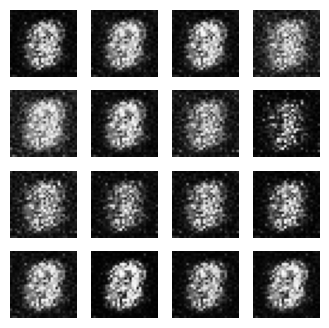

Epoch: 6, D_loss: 0.600888390964734, G_loss: 1.9649901574551105



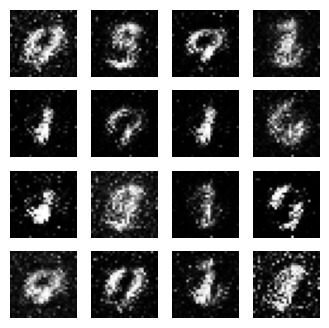

Epoch: 8, D_loss: 0.7929824068426704, G_loss: 1.7728920470179717



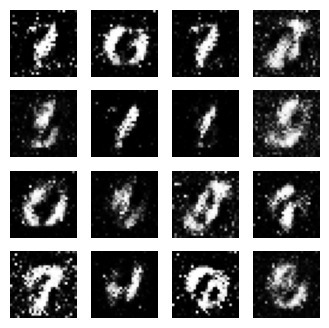

Epoch: 10, D_loss: 0.9416521600623523, G_loss: 1.570081515589544



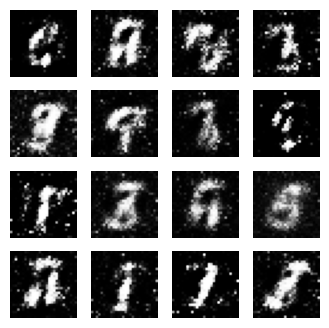

Epoch: 12, D_loss: 0.975695586064582, G_loss: 1.4547346000864767



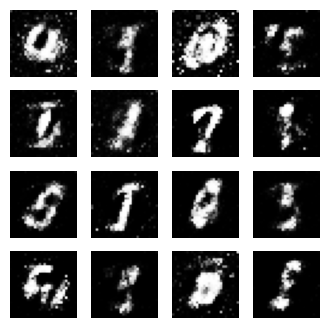

Epoch: 14, D_loss: 1.0640101182804291, G_loss: 1.3856613539962401



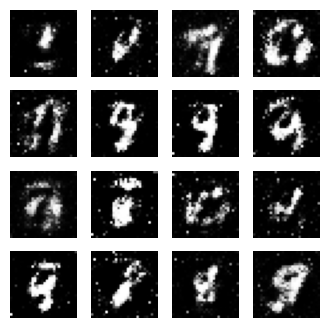

Epoch: 16, D_loss: 1.0721142288205971, G_loss: 1.2998248603326152



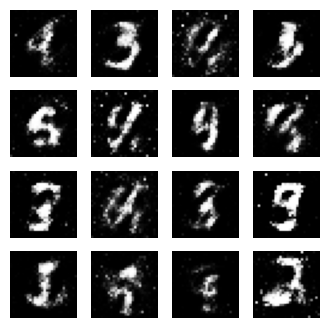

Epoch: 18, D_loss: 1.0980217989887981, G_loss: 1.264843398567961



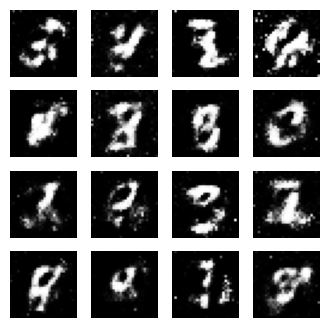

Epoch: 20, D_loss: 1.1013508599366806, G_loss: 1.2420465974186885



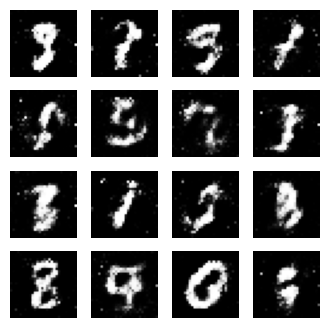

Epoch: 22, D_loss: 1.124092231438025, G_loss: 1.2170777992606798



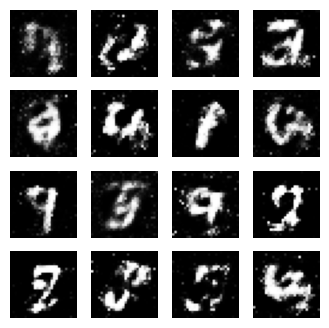

In [ ]:
G_losses, D_losses = train_model(
    G, D, G_optimizer, D_optimizer, criterion, num_epochs=22
)

###### Losses

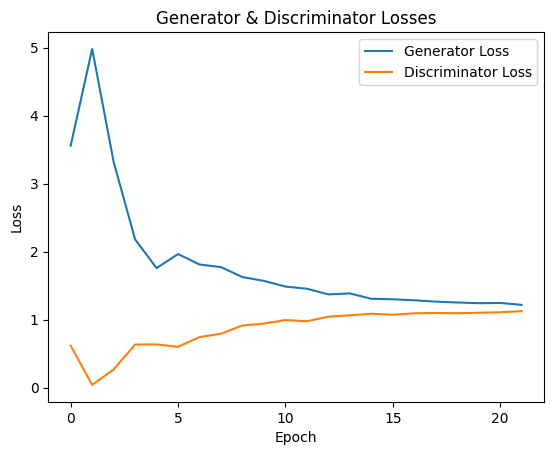

In [ ]:
plot_G_D_losses(G_losses, D_losses)

##### Task 1.1.2.2 - Training for 100k iterations

###### Network Initialization

In [ ]:
G = Generator().to(device)
D = DiscriminatorLogits().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

###### Training

See explanation for number of epochs in Task 1.1.

Epoch: 11, D_loss: 1.0215490863697252, G_loss: 1.4533990434546862



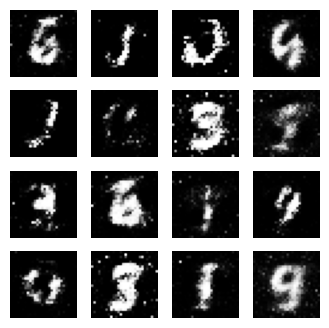

Epoch: 22, D_loss: 1.1609181882604844, G_loss: 1.1295614028816672



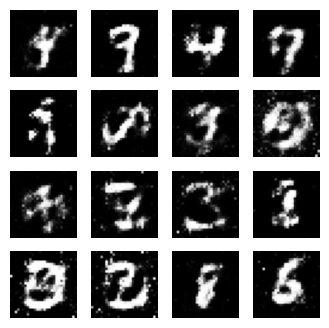

Epoch: 33, D_loss: 1.226298260205329, G_loss: 0.9871554521002917



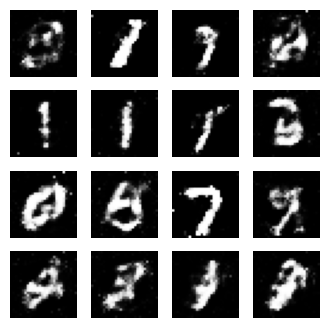

Epoch: 44, D_loss: 1.2603765567058942, G_loss: 0.9168777227910632



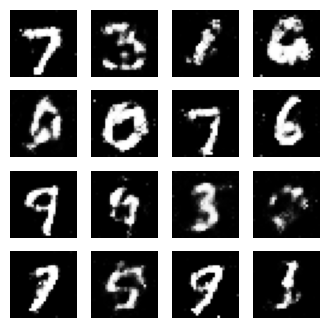

Epoch: 55, D_loss: 1.2801989093025314, G_loss: 0.8759546203572569



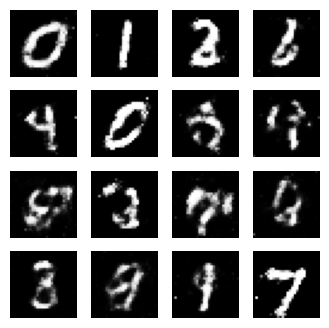

Epoch: 66, D_loss: 1.2886518190357448, G_loss: 0.8589940163343668



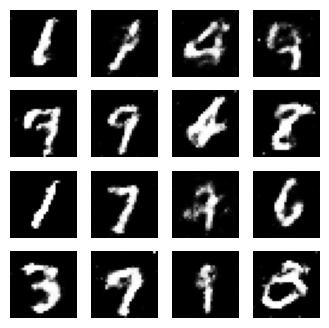

Epoch: 77, D_loss: 1.3052455404397645, G_loss: 0.8387611142599214



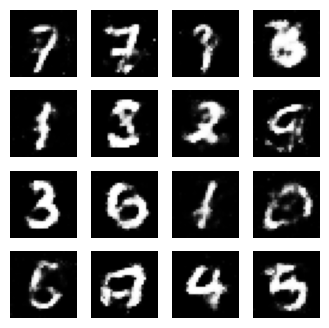

Epoch: 88, D_loss: 1.306740782304151, G_loss: 0.8263487184823768



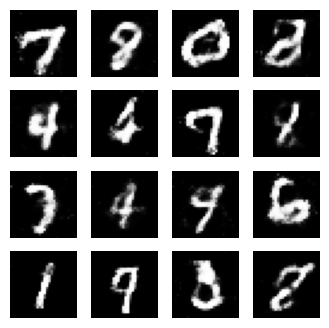

Epoch: 99, D_loss: 1.3108819355450674, G_loss: 0.8257322031507625



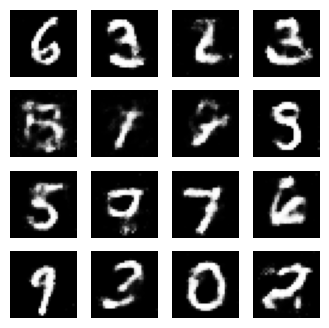

Epoch: 110, D_loss: 1.3112533011075145, G_loss: 0.8242832330654881



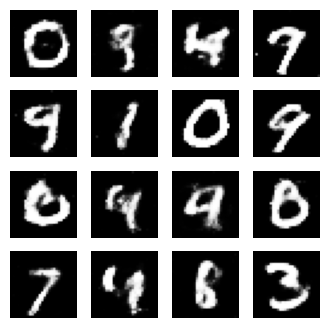

In [ ]:
G_losses, D_losses = train_model(
    G, D, G_optimizer, D_optimizer, criterion, num_epochs=110
)

###### Losses

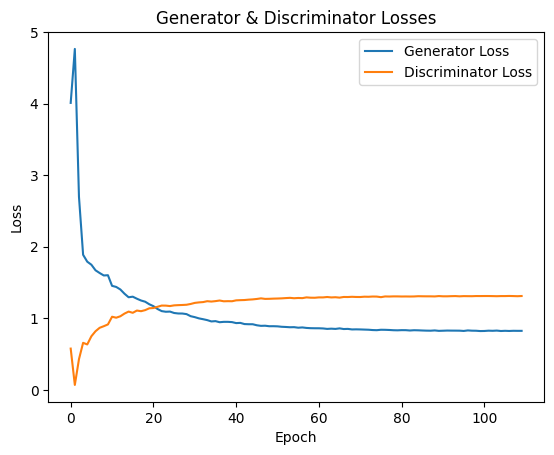

In [ ]:
plot_G_D_losses(G_losses, D_losses)

##### Comparison with BCE Loss GAN

I have noticed that using BCELoss runs for a slightly shorter time while also converging faster than BCEWithLogitsLoss.

However, using BCEWithLogitsLoss outputs better results in the end. (Generated images are less blurry)

The better results are probably due to the trick that the logits loss function uses. Combining a Sigmoid layer with BCELoss in a single class is more numerically stable because of the log-sum-exp trick.

### Task 1.2 - Conditional GAN

#### Helpers

##### Class Definitions

###### Conditional Generator

In [ ]:
class ConditionalGenerator(Generator):
    def __init__(self):
        super().__init__()

        self.linear1 = torch.nn.Linear(Z_dim + l_dim, h1_dim)
        self.label_embedding = nn.Embedding(l_dim, l_dim)

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x_c = torch.cat([x, c], 1)

        h1 = self.dropout(self.leaky_relu(self.linear1(x_c)))
        h2 = self.dropout(self.leaky_relu(self.linear2(h1)))

        return self.tanh(self.linear3(h2))

###### Conditional Discriminator

In [ ]:
class ConditionalDiscriminator(Discriminator):
    def __init__(self):
        super().__init__()

        self.linear1 = torch.nn.Linear(X_dim + l_dim, h1_dim)
        self.label_embedding = nn.Embedding(l_dim, l_dim)

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x_c = torch.cat([x, c], 1)

        h1 = self.dropout(self.leaky_relu(self.linear1(x_c)))

        return self.linear2(h1)

##### Train function

In [ ]:
def train_model_CGAN(G, D, G_optimizer, D_optimizer, criterion, num_epochs):
    log_epoch = max(num_epochs // 10, 1)
    real_labels = torch.ones(BATCH_SIZE, 1).to(device)
    fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

    G_losses_per_epoch, D_losses_per_epoch = [], []

    for epoch in range(num_epochs):
        G_losses, D_losses = [], []
        G.train()
        D.train()

        for images, labels in X_train:
            images = images.view(-1, X_dim).to(device)
            labels = labels.to(device)

            # Train Discriminator
            z = torch.randn(BATCH_SIZE, Z_dim).to(device)
            random_labels = torch.randint(l_dim, (BATCH_SIZE, )).to(device)

            D_optimizer.zero_grad()

            ## Real images
            D_real = D(images, labels)

            D_real_loss = criterion(D_real, real_labels)

            ## Generated images
            G_sample = G(z, random_labels)
            D_fake = D(G_sample, random_labels)

            D_fake_loss = criterion(D_fake, fake_labels)

            ## Aggregated loss
            D_loss = D_real_loss + D_fake_loss

            D_loss.backward()
            D_optimizer.step()

            D_losses.append(D_loss.item())

            # Train Generator with generated images
            z = torch.randn(BATCH_SIZE, Z_dim).to(device)
            random_labels = torch.randint(l_dim, (BATCH_SIZE, )).to(device)

            G_optimizer.zero_grad()

            G_sample = G(z, random_labels)
            D_fake = D(G_sample, random_labels)

            G_loss = criterion(D_fake, real_labels)

            G_loss.backward()
            G_optimizer.step()

            G_losses.append(G_loss.item())

        G_loss_per_epoch = np.mean(G_losses)
        D_loss_per_epoch = np.mean(D_losses)

        G_losses_per_epoch.append(G_loss_per_epoch)
        D_losses_per_epoch.append(D_loss_per_epoch)

        if (epoch + 1) % log_epoch == 0:
            G.eval()

            print(f"Epoch: {epoch + 1}", end=", ")
            print(f"D_loss: {D_loss_per_epoch}, G_loss: {G_loss_per_epoch}\n")

            z = torch.randn(4 * 4, Z_dim).to(device)
            random_labels = torch.randint(l_dim, (4 * 4, )).to(device)

            with torch.no_grad():
                G_sample = G(z, random_labels).detach().cpu()

            plot_samples_4x4_grid(G_sample)

    return G_losses_per_epoch, D_losses_per_epoch

#### Network Initialization

In [ ]:
G = ConditionalGenerator().to(device)
D = ConditionalDiscriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

#### Training

Epoch: 11, D_loss: 0.9560447890577856, G_loss: 1.5394507233081276



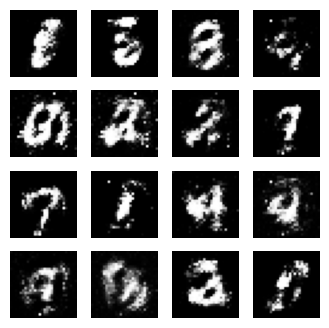

Epoch: 22, D_loss: 1.1580402755050292, G_loss: 1.1440484334844916



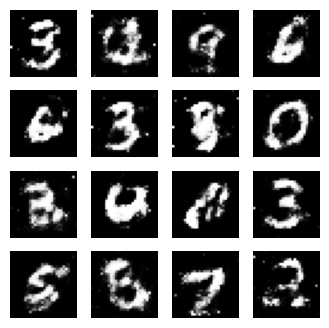

Epoch: 33, D_loss: 1.21611221152156, G_loss: 1.0037242419055585



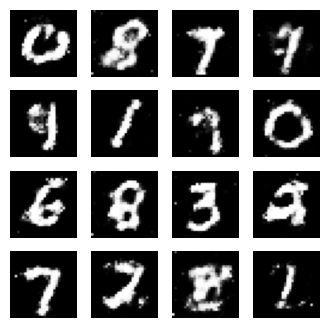

Epoch: 44, D_loss: 1.2508905380487187, G_loss: 0.9249267112483591



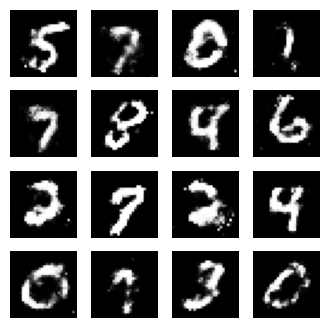

Epoch: 55, D_loss: 1.2773549181420114, G_loss: 0.885825385660601



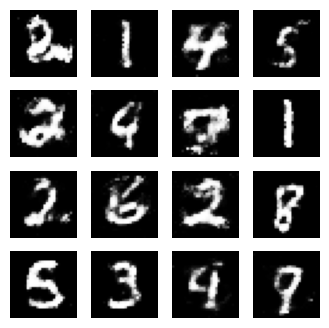

Epoch: 66, D_loss: 1.287363962277277, G_loss: 0.8672230327014862



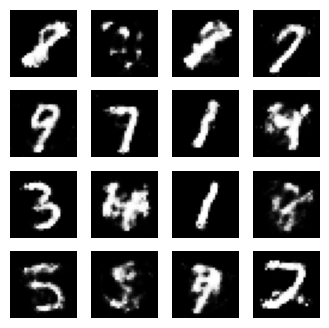

Epoch: 77, D_loss: 1.3009210490366183, G_loss: 0.8434233496257819



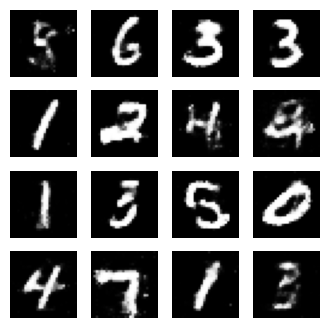

Epoch: 88, D_loss: 1.3010236682606864, G_loss: 0.8346655793098401



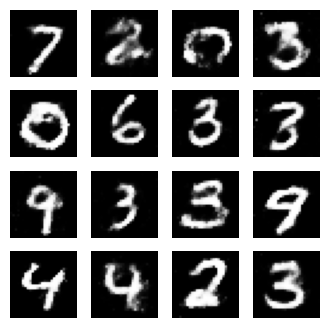

Epoch: 99, D_loss: 1.307347219298209, G_loss: 0.8285398277808915



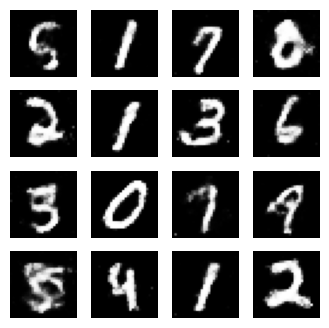

Epoch: 110, D_loss: 1.3059186392176494, G_loss: 0.8313658006544937



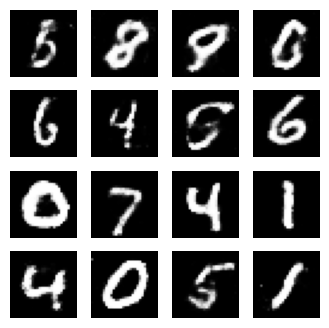

In [ ]:
G_losses, D_losses = train_model_CGAN(
    G, D, G_optimizer, D_optimizer, criterion, num_epochs=110
)

#### Losses

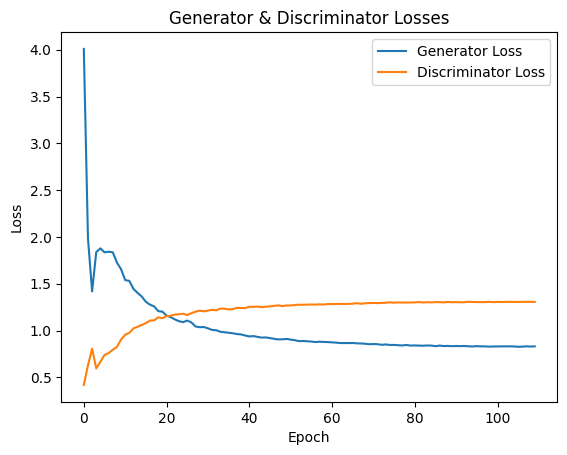

In [ ]:
plot_G_D_losses(G_losses, D_losses)

#### Testing the network with specific digits

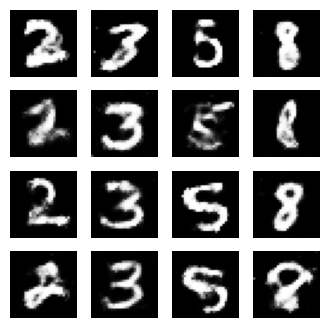

In [ ]:
G.eval()

z = torch.randn(4 * 4, Z_dim).to(device)
desired_labels = torch.tensor([2, 3, 5, 8] * 4).to(device)

with torch.no_grad():
    G_sample = G(z, desired_labels).detach().cpu()

plot_samples_4x4_grid(G_sample)

## Task 2 - Adversarial CNN

### Helpers

#### CNN Class Definition

In [219]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        h1 = self.pool(self.relu(self.conv1(x)))

        h2 = self.pool(self.relu(self.conv2(h1)))
        h2 = torch.flatten(h2, 1)

        h3 = self.relu(self.fc1(h2))

        return self.fc2(h3)

#### FGSM Attack

FGSM works by exploiting the gradients of the neural network to create perturbations that maximize the loss of the model on a particular input.
    
These perturbations are small and often imperceptible to humans, but they can deceive the model into classifying the input incorrectly.

In [277]:
def fgsm_attack(images):
    resulting_images = torch.tensor([])
    gradient_signs = images.grad.data.sign()

    with torch.no_grad():
        for i, image in enumerate(images):
            gradient_sign = gradient_signs[i]

            perturbed_image = image - gradient_sign / 4
            clamped_image = torch.clamp(perturbed_image, 0, 1)

            resulting_images = torch.cat((resulting_images, clamped_image), 1)

        return resulting_images

#### Plot original and adversarial images

In [308]:
def plot_probability_for_image(image, output, step=None):
    with torch.no_grad():
        label = np.argmax(output).item()
        probability = round(F.softmax(output, dim=-1)[label].item() * 100, 2)

        plt.imshow(image.reshape(28, 28), cmap='gray')

        title = f"Step: {step}, " if step is not None else ""
        title += f"Label: {label}, Probability: {probability}%"
        plt.title(title)

        plt.show()

### Network Initialization

In [222]:
NUM_EPOCHS = 2
NUM_TEST_BATCHES = len(X_test)

model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

### Training CNN

In [223]:
for epoch in range(NUM_EPOCHS):
    train_losses = []

    model.train()

    for images, labels in X_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output, labels)
        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())

    test_losses = []
    no_correct_guesses = 0

    model.eval()

    with torch.no_grad():
        for images, labels in X_test:
            images, labels = images.to(device), labels.to(device)

            output = model(images)

            loss = criterion(output, labels)
            test_losses.append(loss.item())

            guess = np.argmax(output, axis=1)
            no_correct_guesses += (guess == labels).sum().item()

    train_loss = round(np.mean(train_losses), 3)
    test_loss = round(np.mean(test_losses), 3)
    accuracy = round(
        no_correct_guesses * 100 / (NUM_TEST_BATCHES * BATCH_SIZE),
        2
    )

    print(f"Epoch: {epoch + 1}", end=', ')
    print(f"Training Loss: {train_loss}", end=', ')
    print(f"Test Loss: {test_loss}", end=', ')
    print(f"Test Accuracy: {accuracy}%")

Epoch: 1, Training Loss: 0.166, Test Loss: 0.054, Test Accuracy: 98.26%
Epoch: 2, Training Loss: 0.048, Test Loss: 0.037, Test Accuracy: 98.76%


### Fool the CNN into classifying 4s as 9s

#### Extract images of 4s

In [305]:
images_of_4s = torch.tensor([], device=device)

for images, labels in X_train:
    images, labels = images.to(device), labels.to(device)

    indexes_of_4s = np.where(labels == 4)
    found_images_of_4s = images[indexes_of_4s]

    current_number_of_images = len(images_of_4s)
    no_images_to_append = min(
        BATCH_SIZE - current_number_of_images,
        len(found_images_of_4s)
    )

    images_of_4s_to_append = found_images_of_4s[:no_images_to_append]
    images_of_4s = torch.cat((images_of_4s, images_of_4s_to_append))

    current_number_of_images = len(images_of_4s)

    if current_number_of_images == BATCH_SIZE:
        break

#### Apply fgsm attack to perturbate 4s into 9s

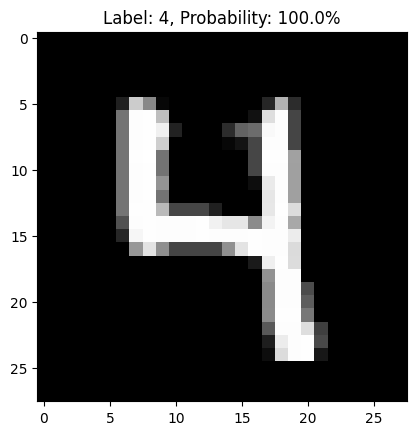

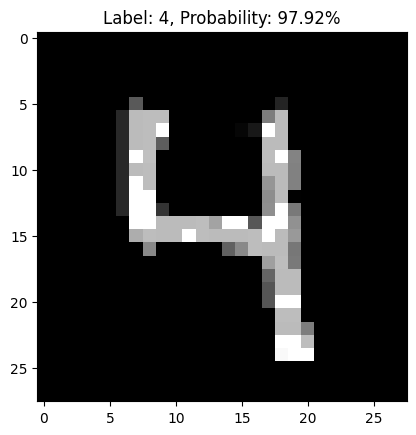

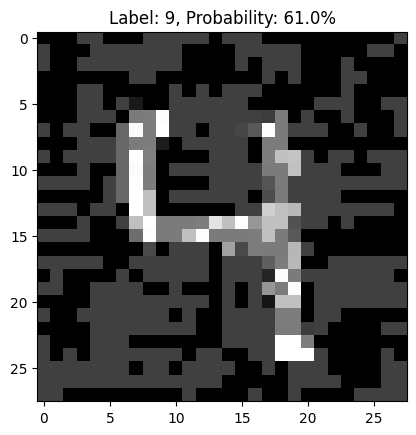

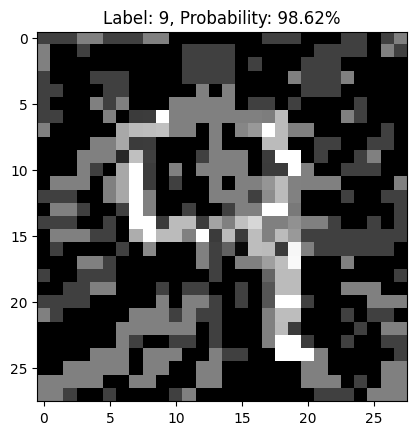

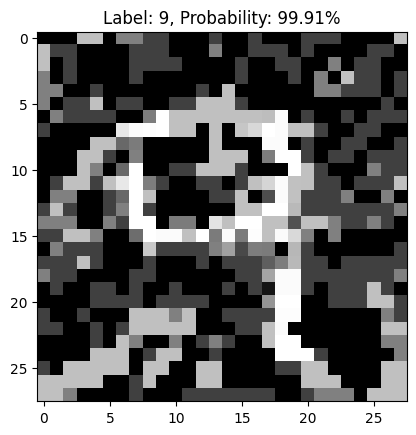

In [309]:
NUM_ITERATIONS = 5
adversarial_images_of_4s = images_of_4s.clone()
labels_of_9s = torch.full((BATCH_SIZE, ), 9, device=device)

model.eval()

for _ in range(NUM_ITERATIONS):
    adversarial_images_of_4s.requires_grad = True
    model.zero_grad()

    output = model(adversarial_images_of_4s)

    loss = criterion(output, labels_of_9s)
    loss.backward()

    plot_probability_for_image(adversarial_images_of_4s[0], output[0])

    new_images = fgsm_attack(adversarial_images_of_4s)
    new_images = new_images.reshape(adversarial_images_of_4s.shape)

    adversarial_images_of_4s = new_images.clone()

### Optimize noise to be classified as 9

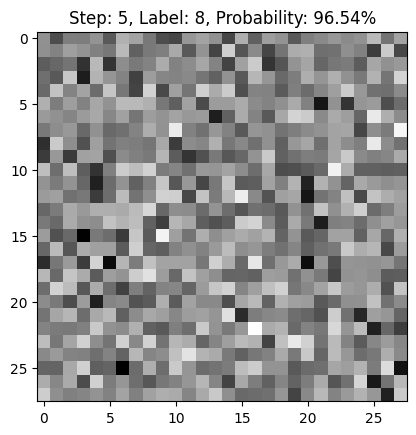

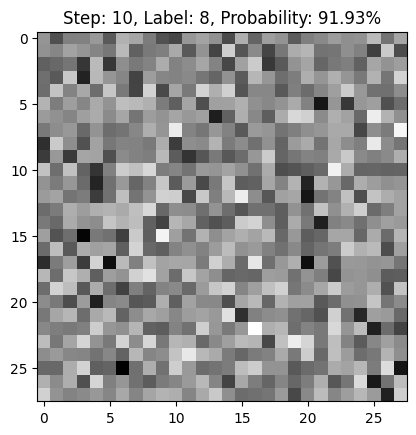

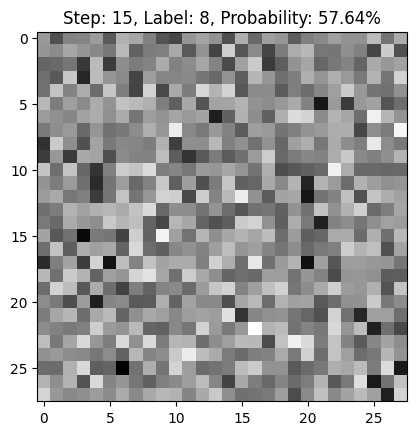

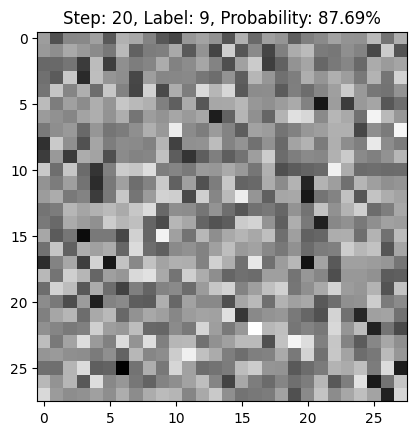

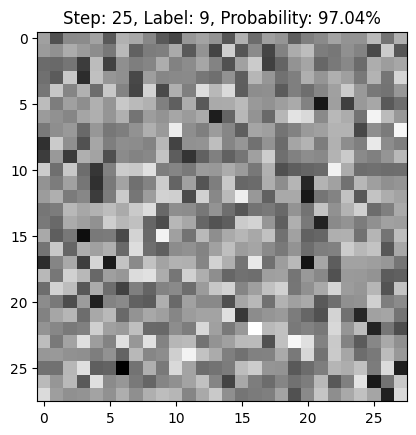

In [315]:
NUM_ITERATIONS = 25

noise = torch.randn((BATCH_SIZE, 1, 28, 28), device=device, requires_grad=True)
target = torch.full((BATCH_SIZE, ), 9, device=device)

optimizer = optim.Adam([noise], lr=0.01)

model.eval()

for step in range(NUM_ITERATIONS):
    optimizer.zero_grad()
    output = model(noise)

    loss = criterion(output, target)
    loss.backward()

    optimizer.step()

    if (step + 1) % 5 == 0:
        plot_probability_for_image(noise[0], output[0], step=step + 1)

### Comparison

Tricking the CNN by tweaking real images converges much faster than optimizing noise into classes.

## Task 3 - Stable Diffusion

### Helpers

#### Display images with labels

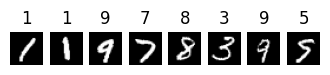

In [101]:
def display_images_with_labels(images, labels):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images/2, 2.5))

    for image, label, ax in zip(images, labels, axes.flatten()):
        ax.imshow(image.permute(1, 2, 0), cmap='gray')

        ax.set_title(label.item())
        ax.axis('off')

    plt.show()

images, labels = next(iter(X_train))
display_images_with_labels(images[:8], labels[:8])

#### Corrupt image (Noise)

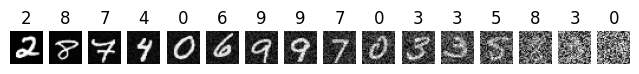

In [103]:
def corrupt(image, noise_strength):
    noise = torch.rand_like(image, device=device)
    noise_strength = noise_strength.reshape(-1, 1, 1, 1)

    return image * (1 - noise_strength) + noise * noise_strength

images, labels = next(iter(X_train))
images, labels = images.to(device), labels.to(device)
noise_strength = torch.linspace(0, 1, BATCH_SIZE, device=device)

corrupted_images = corrupt(images, noise_strength).cpu()
display_images_with_labels(corrupted_images[::4], labels[::4])

#### Conditional U-Net Class Definition

**Conditional U-Net**

Implement a basic U-Net model modified to accept an additional conditioning channel. The conditioning is achieved via embeddings associated with each label, which are concatenated with the input images.

**Embeddings**

The embeddings are different noise associated with different labels.

**Network Configuration**

Construct separate down_layers and up_layers using convolutional layers, defined to progressively downsample and then upsample the input.
Employ SiLU (Sigmoid Linear Unit) as the activation function for its smooth non-linearity and efficient gradient propagation.

**Forward Pass**

Concatenate the input with label-specific embeddings, enriching the feature space with label-dependent information.

In [16]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1):
        super().__init__()

        self.silu = nn.SiLU()
        self.upscale = nn.Upsample(scale_factor=2)
        self.downscale = nn.MaxPool2d(kernel_size=2)
        self.embedding = torch.randn(10, 1, 28, 28).to(device)

        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])

        self.up_layers = nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])


    def forward(self, x, labels):
        c = self.embedding[labels]
        x_c = torch.cat([x, c], dim=1)

        h_i, h = x_c, []

        # Downsample
        for i, layer in enumerate(self.down_layers):
            h_i = self.silu(layer(h_i))

            # If we're not at the final downsampling layer
            if i < 2:
                # Skip connection
                h.append(h_i)

                # Downscale
                h_i = self.downscale(h_i)

        # Upsample
        for i, layer in enumerate(self.up_layers):
            # If we're not at the first upsampling layer
            if i > 0:
                # Upscale
                h_i = self.upscale(h_i)

                # Fetch skip connection's value
                h_i += h.pop()

            h_i = self.silu(layer(h_i))

        return h_i

### Network Initialization

In [90]:
NUM_EPOCHS = 10

model = ConditionalUNet().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

### Training

#### Implementation

In [91]:
losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    losses_per_epoch = []

    for images, labels in X_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        noise_strength = torch.rand(BATCH_SIZE).to(device)
        corrupted_images = corrupt(images, noise_strength)

        output = model(corrupted_images, labels)

        # How similar is the output to the original image
        loss = criterion(output, images)
        loss.backward()

        optimizer.step()

        losses_per_epoch.append(loss.item())

    train_loss_per_epoch = np.mean(losses_per_epoch)
    losses.append(train_loss_per_epoch)

    print(f"Epoch: {epoch + 1}, Training Loss: {round(train_loss_per_epoch, 2)}")

Epoch: 1, Training Loss: 0.48
Epoch: 2, Training Loss: 0.46
Epoch: 3, Training Loss: 0.46
Epoch: 4, Training Loss: 0.46
Epoch: 5, Training Loss: 0.46
Epoch: 6, Training Loss: 0.46
Epoch: 7, Training Loss: 0.46
Epoch: 8, Training Loss: 0.46
Epoch: 9, Training Loss: 0.45
Epoch: 10, Training Loss: 0.45


#### Losses

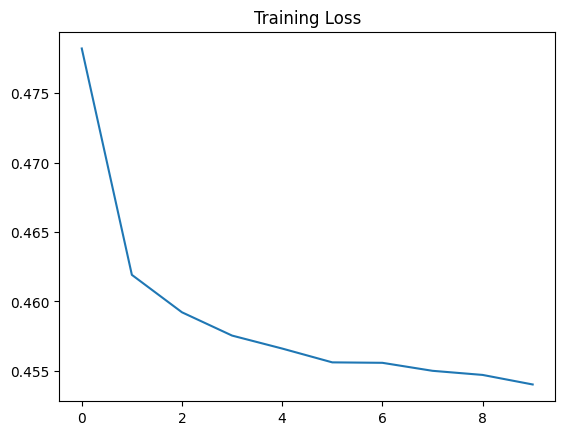

In [92]:
plt.plot(losses)

plt.title('Training Loss')

plt.show()

### Testing

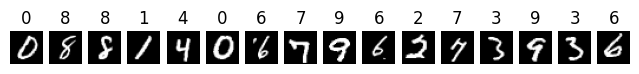

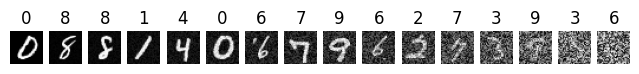

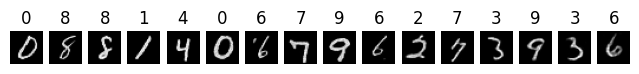

In [93]:
images, labels = next(iter(X_train))
images, labels = images.to(device), labels.to(device)
noise_strength = torch.linspace(0, 1, BATCH_SIZE, device=device)

corrupted_images = corrupt(images, noise_strength).to(device)

model.eval()

with torch.no_grad():
  output = model(corrupted_images, labels)

images = images.cpu()
corrupted_images = corrupted_images.cpu()
output = output.cpu()
labels = labels.cpu()

display_images_with_labels(images[::4], labels[::4])
display_images_with_labels(corrupted_images[::4], labels[::4])
display_images_with_labels(output[::4], labels[::4])

### Generate images from noise

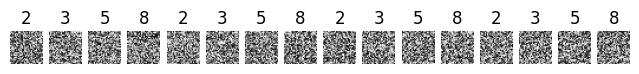

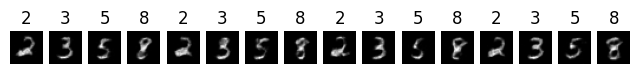

In [121]:
images, _ = next(iter(X_test))
images = images.to(device)

noise = torch.rand_like(images, device=device)
labels = torch.tensor([2, 3, 5, 8] * 16).to(device)

model.eval()

with torch.no_grad():
    output = model(noise, labels)

display_images_with_labels(noise.cpu()[:16], labels.cpu()[:16])
display_images_with_labels(output.cpu()[:16], labels.cpu()[:16])

### Results Comparison with CGAN

The CGAN seems to generate better-looking images. This is probably due to the complexity of the network. Since UNet is much more complex, it would probably need much more training to perform better.

## GANs vs Stable Diffusion

Both GANs and Stable Diffusion are used for generative tasks, but they differ in architecture, training methods, and sample generation.

* **GANs**
  * contain a generator and a descriminator
  * the generator generates fake samples, while the discriminator tries to distinguish between real and fake samples
  * they are trained simultaneously in a competitive manner
* **Stable Diffusion**
  * based on diffusion process, where noise is added to an image iteratively to generate realistic samples
  * these models learn a diffusion process that transforms a simple distribution into the data distribution (images)
  * no discriminator involved